In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import astropy.units as u

In [3]:
from gammapy.maps import MapAxis
from gammapy.modeling import Fit
from gammapy.modeling.models import SkyModel

from astropy.coordinates import SkyCoord

import ogip_spectrum_dataset
from models import XspecSpectralModel

from astromodels.xspec.factory import XS_wabs
from astromodels import Powerlaw

[WARNING ] The naima package is not available. Models that depend on it will not be available
[WARNING ] The GSL library or the pygsl wrapper cannot be loaded. Models that depend on it will not be available.
[WARNING ] The ebltable package is not available. Models that depend on it will not be available
[INFO    ] Starting 3ML!
Loading xspec models...done


In [4]:
filename = "../XMM_test_files/PN_PWN.grp"
pn_dataset = ogip_spectrum_dataset.StandardOGIPDataset.read(filename)
filename = "../XMM_test_files/MOS1_PWN.grp"
mos1_dataset = ogip_spectrum_dataset.StandardOGIPDataset.read(filename)
filename = "../XMM_test_files/MOS2_PWN.grp"
mos2_dataset = ogip_spectrum_dataset.StandardOGIPDataset.read(filename)

/home/lucagiunti/miniconda3/envs/threeML/lib/python3.7/site-packages/astropy/units/quantity.py:486: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/lucagiunti/miniconda3/envs/threeML/lib/python3.7/site-packages/astropy/units/quantity.py:486: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/lucagiunti/miniconda3/envs/threeML/lib/python3.7/site-packages/astropy/units/quantity.py:486: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


In [5]:
pn_dataset.mask_fit = pn_dataset._geom.energy_mask(1.5*u.keV, 10*u.keV)
mos1_dataset.mask_fit = mos1_dataset._geom.energy_mask(1.5*u.keV, 8*u.keV)
mos2_dataset.mask_fit = mos2_dataset._geom.energy_mask(1.5*u.keV, 8*u.keV)

(1.0, 10.0)

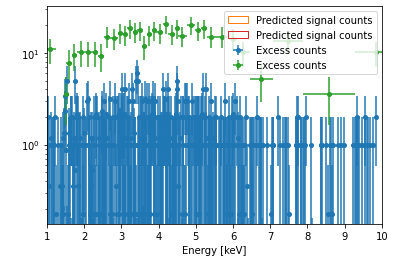

In [6]:
ax = pn_dataset.plot_excess()
ax = pn_dataset.grouped.plot_excess()
plt.xlim(1,10)

(1.0, 10.0)

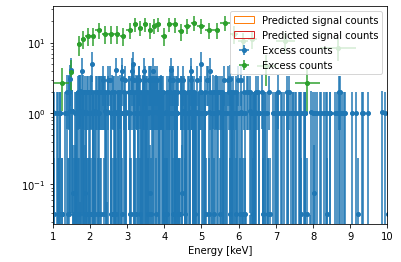

In [7]:
ax = mos1_dataset.plot_excess()
ax = mos1_dataset.grouped.plot_excess()
plt.xlim(1,10)

(1.0, 10.0)

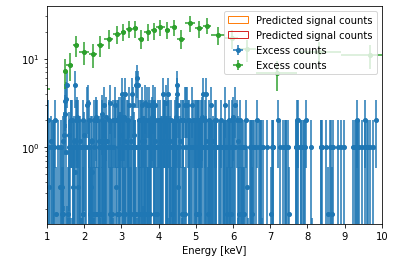

In [8]:
ax = mos2_dataset.plot_excess()
ax = mos2_dataset.grouped.plot_excess()
plt.xlim(1,10)

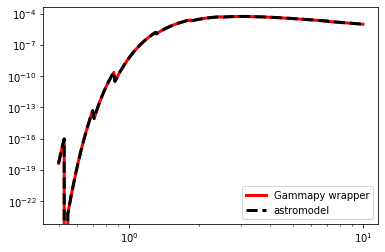

In [9]:
fig, ax = plt.subplots()
energy_grid = np.linspace(0.5, 10.0, 1000) * u.keV

plaw = Powerlaw(index=-2, K=1e-3, piv=1)
abs_model = XS_wabs(nh=5)

# Gammapy wrapper
f1 = XspecSpectralModel(plaw) 
f2 = XspecSpectralModel(abs_model)
f3 = f1 * f2
ax.loglog(energy_grid, f3(energy_grid), color="r", lw=3, label="Gammapy wrapper")

#Plain astromodels
plaw_with_abs = plaw * abs_model
ax.loglog(energy_grid.value, plaw_with_abs(energy_grid.value), color="k", ls="--", lw=3, label="astromodel")

plt.legend()

In [10]:
model = SkyModel(spectral_model=f3)

In [11]:
from gammapy.datasets import Datasets
xmm_datasets = Datasets(datasets=[pn_dataset, mos1_dataset, mos2_dataset])
xmm_datasets.models=[model]

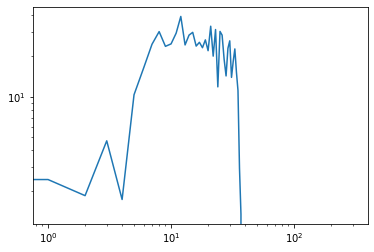

In [12]:
plt.loglog(np.squeeze(pn_dataset.npred_signal().data))

In [13]:
xmm_datasets.models[0].spectral_model.parameters["piv"].frozen = True
xmm_datasets.models[0].spectral_model.parameters["K"].min = 0
xmm_datasets.models[0].spectral_model.parameters["nh"].min = 0

In [14]:
xmm_datasets.models.to_parameters_table()

model,type,name,value,unit,error,min,max,frozen,link
str8,str8,str5,float64,str1,int64,float64,float64,bool,str1
mfl-UeNp,spectral,K,1.0000e-03,,0.000e+00,0.000e+00,nan,False,
mfl-UeNp,spectral,piv,1.0000e+00,,0.000e+00,nan,nan,True,
mfl-UeNp,spectral,index,-2.0000e+00,,0.000e+00,nan,nan,False,
mfl-UeNp,spectral,nh,5.0000e+00,,0.000e+00,0.000e+00,nan,False,


In [15]:
%%time
fit = Fit()
fit_result = fit.run(xmm_datasets)

CPU times: user 47.7 s, sys: 2.06 ms, total: 47.7 s
Wall time: 47.7 s


In [16]:
print(fit_result.parameters.to_table())

  type    name    value    unit   error      min    max frozen link
-------- ----- ----------- ---- --------- --------- --- ------ ----
spectral     K  5.7161e-04      2.789e-04 0.000e+00 nan  False     
spectral   piv  1.0000e+00      0.000e+00       nan nan   True     
spectral index -1.8529e+00      2.846e-01       nan nan  False     
spectral    nh  6.0990e+00      1.059e+00 0.000e+00 nan  False     


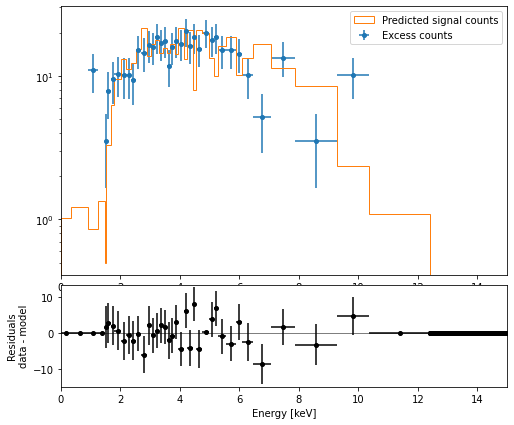

In [17]:
pn_dataset.plot_fit()

<AxesSubplot:xlabel='Energy [keV]', ylabel='Residuals (data - model)'>

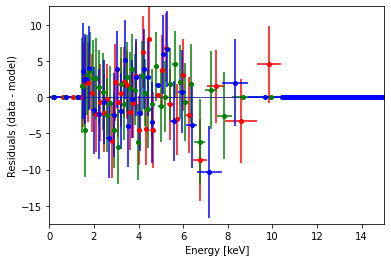

In [18]:
pn_dataset.plot_residuals_spectral(color="r")
mos1_dataset.plot_residuals_spectral(color="g")
mos2_dataset.plot_residuals_spectral(color="b")

# Compare with reference results obtained with sherpa

Reference sherpa notebook: https://github.com/luca-giunti/share/blob/master/CIAO_sherpa_validation_nb.ipynb

In [19]:
amplitude_sherpa = (0.000569626, 0.000251357)
index_sherpa = (1.85112, 0.261476)
nh_sherpa = (6.11597, 0.904329)

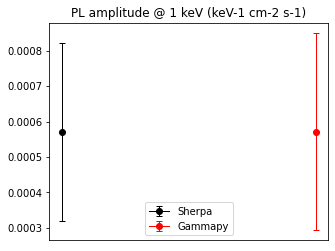

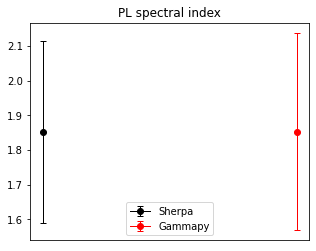

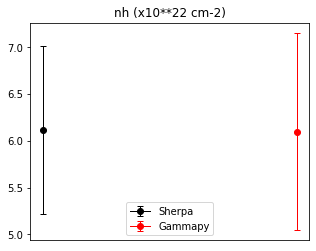

In [20]:
opts = {"marker": "o", "lw": 1, "capsize": 3}
pars_sherpa = [amplitude_sherpa, index_sherpa, nh_sherpa]
fit_result.parameters["index"].value = abs(fit_result.parameters["index"].value)
pars_gammapy = [fit_result.parameters["K"], fit_result.parameters["index"], fit_result.parameters["nh"]]
titles = ["PL amplitude @ 1 keV (keV-1 cm-2 s-1)", "PL spectral index", "nh (x10**22 cm-2)"]

for par_sherpa, par_gammapy, title in zip(pars_sherpa, pars_gammapy, titles):
    plt.figure(figsize=(5, 4))
    plt.errorbar(0, par_sherpa[0], yerr=par_sherpa[1], color="k", label="Sherpa", **opts)
    plt.errorbar(1, par_gammapy.value, yerr=par_gammapy.error, color="r", label="Gammapy", **opts)
    plt.xticks([])
    plt.title(title)
    plt.legend()
    plt.show()
    plt.close()